In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['TOKENIZERS_PARALLELISM']='true'

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY", None)
os.environ['LANGCHAIN_PROJECT']="LangGraph Plan & Execute"

In [2]:
from langchain_ibm import WatsonxLLM, ChatWatsonx
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

def watsonx_model(model_id="mistralai/mixtral-8x7b-instruct-v01", decoding_method='greedy', max_new_tokens=4096, 
                  min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):
    params = {
        GenParams.DECODING_METHOD: decoding_method,
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_new_tokens,
        GenParams.RANDOM_SEED: 42,
        GenParams.TEMPERATURE: temperature,
        GenParams.TOP_K: top_k,
        GenParams.TOP_P: top_p,
        GenParams.REPETITION_PENALTY: repetition_penalty
    }
    ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
    project_id = os.getenv("PROJECT_ID", None)
    api_key = os.getenv("API_KEY")
    watsonx_llm = ChatWatsonx(
        model_id=model_id,
        url=ibm_cloud_url,
        apikey=api_key,
        project_id=project_id,
        params=params,
    )
    return watsonx_llm


In [36]:
watsonx_llm = watsonx_model(model_id="ibm/granite-3-2-8b-instruct", max_new_tokens=16384, temperature=0.0)

In [4]:

from langchain_community.tools import DuckDuckGoSearchRun  # Initialize the tool

search_ddg_tool = DuckDuckGoSearchRun()

tools = [search_ddg_tool]

In [5]:
from langchain import hub
from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
# prompt = hub.pull("ih/ih-react-agent-executor")
# prompt.pretty_print()

prompt = "You are a helpful assistant."
agent_executor = create_react_agent(watsonx_llm, tools, messages_modifier=prompt)

/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langgraph/checkpoint/base.py:18: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.serde.jsonplus import JsonPlusSerializer


In [37]:
response = agent_executor.invoke({"messages": [("user", "Who won the most recent Champions Trophy game?")]})
response

{'messages': [HumanMessage(content='Who won the most recent Champions Trophy game?', additional_kwargs={}, response_metadata={}, id='f2f1a6bf-1046-41c7-a127-2ebfd51a95d5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vpzbDNY5Y', 'type': 'function', 'function': {'name': 'duckduckgo_search', 'arguments': '{"query": "most recent Champions Trophy game"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 120, 'total_tokens': 151}, 'model_name': 'mistralai/mistral-large', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-2398b4a77dd51a445701fbdedbfc2b96', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'most recent Champions Trophy game'}, 'id': 'vpzbDNY5Y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 120, 'output_tokens': 31, 'total_tokens': 151}),
  ToolMessage(content="Afghanistan delivered one of the greatest upsets in Champions Trophy history, knocking out England with a stunning all-round 

In [38]:
print(response['messages'][-1].content)

 Afghanistan won the most recent Champions Trophy game, defeating England with a remarkable performance. Ibrahim Zadran scored a historic 177 runs, and Omarzai took five wickets, leading to England's middle order collapse. This victory was a significant upset in Champions Trophy history.


### The Planner

In [8]:
from pydantic import BaseModel, Field
from typing import List
from langchain_core.prompts import ChatPromptTemplate

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)


planner = planner_prompt | watsonx_llm.with_structured_output(Plan)

In [9]:
plan = planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the Man of the match of the winner of the most recent Champions Trophy game?")
        ]
    }
)
plan

Plan(steps=['Identify the most recent Champions Trophy game', 'Determine the winner of that game', 'Find out the Man of the Match for that game', 'Identify the hometown of the Man of the Match'])

In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. \
Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | watsonx_llm.with_structured_output(Act)

In [11]:
act = replanner.invoke(
    {
        "input": "what is the hometown of the Man of the match of the winner of the most recent Champions Trophy game?",
        "plan": plan,
        "past_steps": [('Identify the most recent Champions Trophy game', 'Determine the winner of that game')],
        
    }
)
act

Act(action=Plan(steps=['Find out the Man of the Match for that game', 'Identify the hometown of the Man of the Match']))

In [12]:
# New steps
new_plan = act.action
new_plan

Plan(steps=['Find out the Man of the Match for that game', 'Identify the hometown of the Man of the Match'])

### Building the Graph

In [13]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):  # our graph state (short term memory in between the steps)
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [26]:
from typing import Literal
from langgraph.graph import END


def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    
    print('-----------------------')
    print('Formatted Task at Execute', task_formatted)
    print('-----------------------')
    
    agent_response = agent_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        print('A response was given!')
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "executor"

In [27]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("executor", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "executor")

# From agent, we replan
workflow.add_edge("executor", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["executor", END],
)

# Compile the graph
app = workflow.compile()

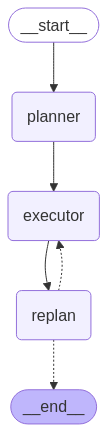

In [28]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Using our Plan & Execute Agent

In [40]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the Man of the match of the winner of the most recent ICC Champions Trophy 2025 game?"}
# inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}

for event in app.stream(inputs, config=config):
    for node_name, output in event.items():
        if node_name != '__end__':
            print(f'Node: {node_name}. Output: {output}')

Node: planner. Output: {'plan': ['Identify the most recent ICC Champions Trophy 2025 game', 'Determine the winner of the identified game', 'Find out the Man of the Match for the winning team', 'Identify the hometown of the Man of the Match']}
-----------------------
Formatted Task at Execute For the following plan:
1. Identify the most recent ICC Champions Trophy 2025 game
2. Determine the winner of the identified game
3. Find out the Man of the Match for the winning team
4. Identify the hometown of the Man of the Match

You are tasked with executing step 1, Identify the most recent ICC Champions Trophy 2025 game.
-----------------------
Node: executor. Output: {'past_steps': [('Identify the most recent ICC Champions Trophy 2025 game', ' The most recent ICC Champions Trophy 2025 game was between India and New Zealand, where India beat New Zealand by 44 runs in the final group game at the Dubai International Cricket Stadium in the United Arab Emirates.')]}
Node: replan. Output: {'plan':

IndexError: list index out of range